In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
import re
import seaborn as sns
import random
from sklearn import svm
import librosa
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import re
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
import pywt
from scipy import signal


import keras
from keras.layers import Conv1D, Embedding, Dropout, MaxPooling1D, GlobalMaxPooling1D, Dense
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, nadam
from keras import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# test data and test data directory 

data_dir = "/content/drive/MyDrive/ELEC378_FinalProject/data/data"

test_dir = "/content/drive/MyDrive/ELEC378_FinalProject/test/test"



Mounted at /content/drive


In [25]:
def FeatureExtraction (dir, split=True): 
 
  '''
  Function for feature extraction. Change this section to change what features we are using. 

  input: a directory of the data. Will split to test and train, a boolean: if split is true, will extract features and labels and store them in 4 arrays:
  train_data, train_label, test_data, test_label. if split is false, function will extract all data provided in the directory and output 2 arrays with values 2 arrays that are empty. 
  Use labeled data and split = false will give you  (train_data, train_label); use unlabled data and split = false will give you (test_data, test_label).

  output: data matrix and lables for both test and train. 

  '''
  audio_files = [f for f in os.listdir(dir) if f.endswith(".wav")]
  
  train_files, test_files = train_test_split(audio_files, test_size=0.15)

  train_wt = []
  train_mfccs = []
  train_label= []

  test_mfccs = []
  test_wt  = []
  test_label = []  
  
  
  for file_name in audio_files:

      # Load audio
      file_path = os.path.join(dir, file_name)
      raw_audio, sr = librosa.load(file_path)

      #if audio is too short, append zeros after it. 
      #noise = np.random.normal(loc=0, scale=0.3)

      if np.shape(raw_audio)[0] < 80000: 
          padded_audio = np.pad(raw_audio, [(0, 80000 - np.shape(raw_audio)[0])], mode='constant')
      else:
          padded_audio = raw_audio

      # now slice so that we guarantee that each array has the same length
      audio = padded_audio[20000:80000]

      # feature extraction
      mfccs  = librosa.feature.mfcc(y = audio, sr = 22050, n_mfcc = 20)
      #delta_mfccs = librosa.feature.delta(y = mfccs)
      spec_centroid = librosa.feature.spectral_centroid(y = audio)
      
      coeffs = pywt.wavedec(audio, 'db1', level =4)

      mfccs_wt = [] 
      

      for i in coeffs:
          mfccsw = librosa.feature.mfcc(y=i, sr=22050, n_mfcc=12)
          # pad the MFCCs to max_len
          
          mfccs_wt.append(mfccsw)

      #mfccs_wt = np.array(mfccs_wt)
      mfccs_wt = np.hstack(mfccs_wt)
      


      #spec_centroid = librosa.feature.spectral_centroid(y = audio)
      
      #spec_contrast = librosa.feature.spectral_contrast (y = audio)

      #morl = morl_wavelet_pca(audio)
    
      # Concatenate
      
      wavelet_features = mfccs_wt
      mfccs_features = np.concatenate([mfccs, spec_centroid])
      #features = morl

      label_map = {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
      label = file_name.split(".")[0]

      #unlabeled data
      if label[:-3] == "sample":
        test_wt.append(wavelet_features)
        test_mfccs.append(mfccs_features)
        test_label.append(label)

      #labeled data
      else:
        if split: 
          if file_name in train_files:
            train_wt.append(wavelet_features)
            train_mfccs.append(mfccs_features)
            label = re.sub('[^a-z]', "", label)
            train_label.append(label_map[label])

          elif file_name in test_files: 
            test_wt.append(wavelet_features)
            test_mfccs.append(mfccs_features)
            label = re.sub('[^a-z]', "", label)
            test_label.append(label_map[label])

        elif not split: 
          
          train_wt.append(wavelet_features)
          train_mfccs.append(mfccs_features)
          label = re.sub('[^a-z]', "", label)
          train_label.append(label_map[label])
  

  train_wt = np.array(train_wt)
  train_mfccs = np.array(train_mfccs)
  train_label = np.array(train_label)


  test_mfccs = np.array(test_mfccs)
  test_wt    = np.array(test_wt)
  test_label = np.array(test_label) 

  #print("feature size is:", np.shape(features))
  #print("spec centroid:", np.shape(spec_centroid))
  return train_mfccs, train_wt, train_label, test_mfccs, test_wt, test_label

In [26]:
X_train_mfccs, X_train_wt, y_train, X_test_mfccs, X_test_wt, y_test = FeatureExtraction(data_dir, split = True)

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

print(X_train_mfccs.shape)

(956, 21, 118)


(956, 12, 120)


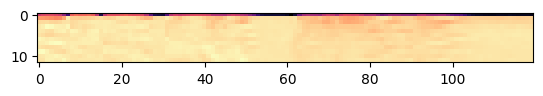

In [19]:
print(X_train_wt.shape)
plt.imshow(X_train_wt[1], cmap = "magma")

In [27]:
def two_branch(mfcc_input_shape, dwt_input_shape, num_classes):     
    
    # Define the input layers for each feature set
    mfcc_input = Input(shape=mfcc_input_shape, name='mfcc_input')
    dwt_input = Input(shape=dwt_input_shape, name='dwt_input')

    # Define the convolutional layers for each feature set
    mfcc_conv1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(mfcc_input)
    mfcc_batch1 = BatchNormalization()(mfcc_conv1)
    mfcc_pool1 = MaxPooling2D(pool_size=(2, 2))(mfcc_batch1)
    mfcc_conv2 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(mfcc_pool1)
    mfcc_batch2 = BatchNormalization()(mfcc_conv2)
    mfcc_conv3 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(mfcc_batch2)
    mfcc_batch3 = BatchNormalization()(mfcc_conv3)
    mfcc_pool3 = MaxPooling2D(pool_size=(2, 2))(mfcc_batch3)
    mfcc_flat = Flatten()(mfcc_pool3)

    dwt_conv1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(dwt_input)
    dwt_batch1 = BatchNormalization()(dwt_conv1)
    dwt_pool1 = MaxPooling2D(pool_size=(2, 2))(dwt_batch1)
    dwt_conv2 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(dwt_pool1)
    dwt_batch2 = BatchNormalization()(dwt_conv2)
    dwt_pool3 = MaxPooling2D(pool_size=(2, 2))(dwt_batch2)
    dwt_flat = Flatten()(dwt_pool3)

    # Merge the feature sets by concatenating the flattened feature vectors
    merged = concatenate([mfcc_flat, dwt_flat])

    # Define the dense layers for classification

    dense1 = Dense(units=1024, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1) # add dropout with rate of 0.5
    dense2 = Dense(units=num_classes, activation='softmax')(dropout1)
    # Define the model with two inputs and one output
    model = Model(inputs=[mfcc_input, dwt_input], outputs=dense2)

    return model

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=17, verbose=1)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1, initial_value_threshold=0.75)

model = two_branch((X_train_mfccs.shape[1], X_train_mfccs.shape[2], 1), (X_train_wt.shape[1], X_train_wt.shape[2], 1), 8)

model.compile(loss='categorical_crossentropy', optimizer="SGD",  metrics=['accuracy'])

# Train the model with the two input feature sets and corresponding labels
history = model.fit( [X_train_mfccs, X_train_wt], y_train_ohe, validation_data=([X_test_mfccs, X_test_wt], y_test_ohe), epochs=60, batch_size=32, callbacks=[checkpoint])


Epoch 1/60
28/30 [===========================>..] - ETA: 0s - loss: 4.9734 - accuracy: 0.2109
Epoch 1: val_accuracy did not improve from 0.75000
30/30 [==============================] - 2s 16ms/step - loss: 4.7694 - accuracy: 0.2207 - val_loss: 1.9952 - val_accuracy: 0.2426
Epoch 2/60
21/30 [====================>.........] - ETA: 0s - loss: 1.7066 - accuracy: 0.3661
Epoch 2: val_accuracy did not improve from 0.75000
30/30 [==============================] - 0s 7ms/step - loss: 1.6810 - accuracy: 0.3724 - val_loss: 1.8946 - val_accuracy: 0.2663
Epoch 3/60
21/30 [====================>.........] - ETA: 0s - loss: 1.3519 - accuracy: 0.5045
Epoch 3: val_accuracy did not improve from 0.75000
30/30 [==============================] - 0s 7ms/step - loss: 1.3640 - accuracy: 0.4937 - val_loss: 1.8532 - val_accuracy: 0.2899
Epoch 4/60
30/30 [==============================] - ETA: 0s - loss: 1.1441 - accuracy: 0.5785
Epoch 4: val_accuracy did not improve from 0.75000
30/30 [=========================

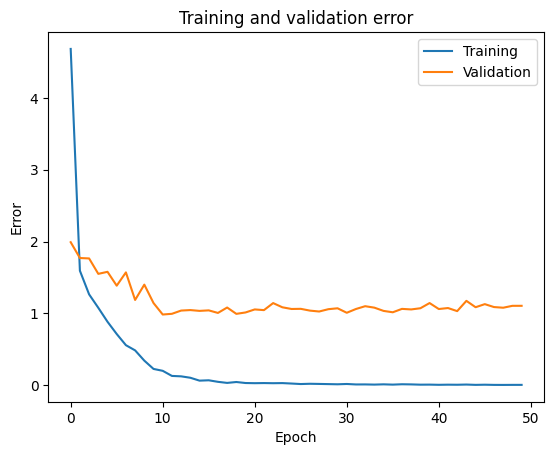

In [29]:
# plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print(X_train_mfccs.shape[1], X_train_mfccs.shape[2], 1)
print(X_train_wt.shape[1], X_train_wt.shape[2], 1)
print(y_test)

26 118 1
75 59 1
[0 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 5 5 5 6 5 6 6 5 6 6 6 6 6 6 6 6
 6 6 6 7 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [ ]:
dummy1, dummy2, dummy3, X_test_mfccs, X_test_wt, y_test = FeatureExtraction(test_dir, split = False)


In [ ]:
model.load_weights('best_model.h5')
y_predicted = model.predict([X_test_mfccs, X_test_wt])

y_predicted_ohv = np.argmax(y_predicted, axis = 1)

print(y_predicted_ohv)
label_map = {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}

def dict_search(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key

y_predicted_label = []
for i in y_predicted_ohv: 
    val = dict_search(label_map, i)
    y_predicted_label.append(val)


print(y_predicted_label)

10/10 [==============================] - 0s 21ms/step
[1 6 6 1 1 4 1 0 6 2 4 2 2 2 2 6 6 2 1 2 7 6 0 6 0 1 1 1 0 0 4 2 6 1 0 0 6
 3 4 0 3 2 1 2 0 1 0 2 2 1 1 2 0 0 6 6 0 1 2 0 7 3 6 4 4 6 2 0 4 0 3 2 2 7
 1 4 7 2 3 6 1 7 7 7 2 4 6 2 3 2 4 7 2 6 1 7 2 1 1 3 2 6 2 6 7 7 1 1 4 4 3
 1 3 6 4 7 3 6 4 0 2 0 7 7 7 7 6 3 7 1 4 0 7 4 0 7 4 3 4 6 2 1 2 0 6 7 4 1
 7 4 1 1 7 0 3 6 3 4 7 3 1 3 1 7 1 1 1 4 2 4 6 6 3 0 7 0 7 7 6 6 2 0 7 1 0
 4 6 7 0 0 7 1 0 1 0 4 3 0 3 2 7 1 0 0 2 1 7 2 7 1 1 1 7 1 4 7 0 1 7 4 3 6
 6 3 6 6 1 2 6 6 6 3 0 4 3 2 7 1 2 1 3 3 4 1 4 1 6 4 0 4 1 2 0 6 7 0 5 0 6
 6 6 4 4 1 7 2 2 6 0 7 0 3 2 3 4 2 7 7 1 0 6 6 4 4 6 2 0 7 4 4 1 2 1 7 0 4
 1 2 1 6 1 7 6 3 0 2 4 2 7 0 1 7 4 2 0]
['calm', 'sad', 'sad', 'calm', 'calm', 'happy', 'calm', 'angry', 'sad', 'disgust', 'happy', 'disgust', 'disgust', 'disgust', 'disgust', 'sad', 'sad', 'disgust', 'calm', 'disgust', 'surprised', 'sad', 'angry', 'sad', 'angry', 'calm', 'calm', 'calm', 'angry', 'angry', 'happy', 'disgust', 'sad', 'calm', 'ang

In [ ]:
import csv

def make_csv(unlabeled_file_name, y_predicted_label):
  with open('prediction.csv', mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['filename', 'label'])
      for i in range(len(unlabeled_file_name)):
        writer.writerow([unlabeled_file_name[i], y_predicted_label[i]])
  file.close()

make_csv(y_test, y_predicted_label)